<a href="https://colab.research.google.com/github/gohsyi/SegNet-ADDA/blob/voc/seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Semantic Segmentation

## What is Semantic Segmentation?

Semantic Segmentation is an image analysis task in which we classify each pixel in the image into a class. <br/>

Similar to what us humans do all the time by default, when are looking then whatever we are seeing if we think of that as an image
then we know what class each pixel of the image belongs to.

Essentially, Semantic Segmentation is the technique through which we can achieve this in Computers.

There are a few more types of Segmentation, you can read about it more here: https://www.learnopencv.com/image-segmentation/
This blog will focus on Semantic Segmentation

So, let's say we have the following image.

![](https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png)
<small> Source: Pexels </small>

And then given the above image its semantically segmentated image would be the following

![](https://lh3.googleusercontent.com/-gdUavPeOxdg/XPPXQngAnvI/AAAAAAAAAQA/yoksBterCGQGt-lv3aX4kfyMUDXTar7yACK8BGAs/s374/index4.png)

As you can see, that each pixel in the image is classified to its respective class.

This is in most simple terms what Semantic Segmentation is.

## Applications of Segmentation


The most common use case for the Semantic Segmentation is in:

1. **Autonomous Driving**

  <img src="https://cdn-images-1.medium.com/max/1600/1*JKmS08bllQ8SCajIPyiBBQ.png" width="400"/> <br/>
  <small> Source: CityScapes Dataset </small>
  
  In autonomous driving, the image which comes in from the camera is semantically segmented, thus each pixel in the image is classified
  into a class. This helps the computer understand what is present in the its surroundings and thus helps the car act accordingly.


2. **Facial Segmentation**

  <img src="https://i.ytimg.com/vi/vrvwfFej_r4/maxresdefault.jpg" width="400"/> <br/>
  <small> Source: https://github.com/massimomauro/FASSEG-repository/blob/master/papers/multiclass_face_segmentation_ICIP2015.pdf </small>

  Facial Segmentation is used for segmenting each part of the face into a category, like lips, eyes etc. This technique is used for
  many purposes such as gender estimation, age estimation, facial expression analysis, emotional analysis and more.
  

3. **Indoor Object Segmentation**

  <img src="https://cs.nyu.edu/~silberman/rmrc2014/header_semantic_segmentation.jpg" width="400"/><br/>
  <small> Source: http://buildingparser.stanford.edu/dataset.html </small>

  Guess where is this used? In AR (Augmented Reality) and VR (Virtual Reality). AR applications when required segments the entire indoor area to understand where there 
  are chairs, tables, people, wall, and other obstacles and so on.
 

4. **Geo-Land Sensing**

  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0924271616305305-fx1_lrg.jpg" width="400"/> <br/>
  <small> Source: https://www.sciencedirect.com/science/article/pii/S0924271616305305 </small>

  Geo Land Sensing is a way of categorizing each pixel in satellite images into a category such that we can track the land cover of each
  area. So, say in some area there is a heavy deforestation taking place then appropriate measures can be taken.


## Using torchvision for Semantic Segmentation

Now before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)

Alright! And just one more thing!
The `torchvision` models outputs an `OrderedDict` and not a `torch.Tensor` <br/>
And in `.eval()` mode it just has one key `out` and thus to get the output we need to get the value
stored in that `key`.

The `out` key of this `OrderedDict` is the key that holds the output. <br/>
So, this `out` key's value has the shape of `[No x Co x Ho x Wo]`.

Now! we are ready to play :)

### FCN with Resnet-101 backbone

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation.

Let's load one up!

In [0]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

And that's it we have a pretrained model of `FCN` (which stands for Fully Convolutional Neural Networks) with a `Resnet101` backbone :)

Now, let's get an image!

2019-06-17 12:18:36 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


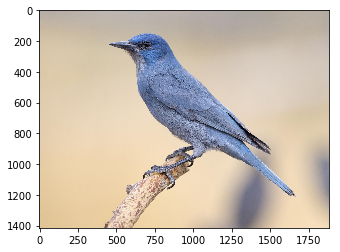

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

Now, that we have the image we need to preprocess it and normalize it! <br/>
So, for the preprocessing steps, we:
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

And lastly, we unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>
We need a batch dimension while passing it to the models.

In [0]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Let's see what the above code cell does </br>
`T.Compose` is a function that takes in a `list` in which each element is of `transforms` type and </br>
it returns a object through which we can
pass batches of images and all the required transforms will be applied to the images.

Let's take a look at the transforms applied on the images:
- `T.Resize(256)` : Resizes the image to size `256 x 256`
- `T.CenterCrop(224)` : Center Crops the image to have a resulting size of `224 x 224`
- `T.ToTensor()` : Converts the image to type `torch.Tensor` and have values between `[0, 1]`
- `T.Normalize(mean, std)` : Normalizes the image with the given mean and standard deviation.

Alright! Now that we have the image all preprocessed and ready! Let's pass it through the model and get the `out` key.<br/>
As I said, the output of the model is a `OrderedDict` so, we need to take the `out` key from that to get the output of the model.

In [0]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


Alright! So, `out` is the final output of the model. And as we can see, its shape is `[1 x 21 x H x W]` as discussed earlier. So, the model was trained on `21` classes and thus our output have `21` channels!<br/>

Now, what we need to do is make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class!

So, the `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

And how do we get there from this `[1 x 21 x H x W]`?<br/>
We take a max index for each pixel position, which represents the class<br/>

In [0]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


Alright! So, we as we can see now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list, 
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]` 
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output!

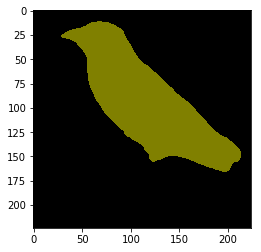

In [0]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

And there we go!!<br/>
Wooohooo! We have segmented the output of the image. 

That's the bird!

Also, Do note that the image after segmentation is smaller than the original image as in the preprocessing step the image is resized and cropped.

Next, let's move all this under one function and play with a few more images!

In [0]:
def segment(net, path, gt_path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

And let's get a new image!

### DeepLabv3

In [0]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 244545539/244545539 [00:04<00:00, 60479182.73it/s]


Alright! Now we have god-level segmentation model!<br/>
Let's see how we perform with the same image on this model!

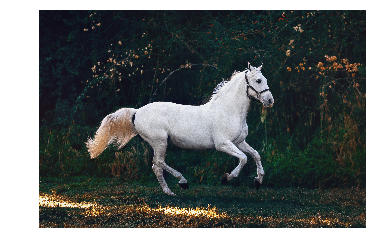

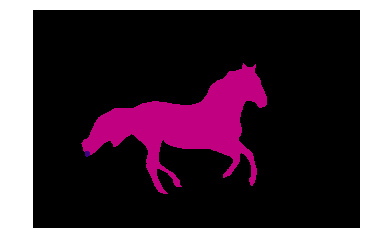

In [0]:
segment(dlab, './horse.png')

Yeah! So, there you go! You can see that, the DeepLab model has also classified the image quite nicely! </br>
But if we take a more complex image! Then we start to see model differences! 

Note: As we saw before the output image size is smaller than the original image as the original image is resized and cropped in the preprocessing step.

Let's try that out!

2019-06-05 13:39:09 URL:https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg [22870459/22870459] -> "person.png" [1]


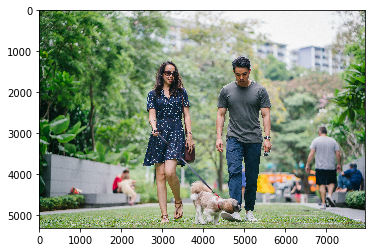

Segmenatation Image on FCN


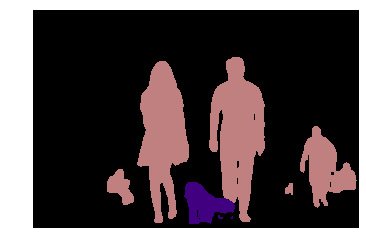

Segmenatation Image on DeepLabv3


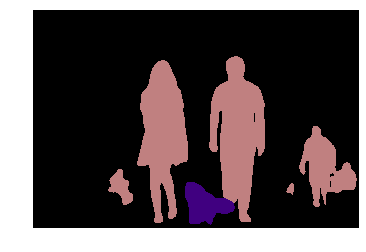

In [0]:
!wget -nv "https://images.pexels.com/photos/1485799/pexels-photo-1485799.jpeg" -O person.png
img = Image.open('./person.png')
plt.imshow(img); plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path='./person.png', show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path='./person.png', show_orig=False)

Okay! You can now see the model differences right?

You can see how FCN fails to capture the continuity of the leg of the cow while DeepLabv3 is able to capture that!

Also, if we look closer into the hand of the human which is on the cow, we can see that the FCN model captures it nicely, not very nicely, but still, while the DeepLabv3 model has captured it too but not that well!

These are a few model differences that be noticed with bare eyes!

Note: As we saw before the output image size is smaller than the original image as the original image is resized and cropped in the preprocessing step.

Do play around with a few more images to see how these models perform in different scenarios.!

## Comparision

For, now we will see how these two models compare with each other in 3 metrics
- Inference time
- Size of the model
- GPU memory used by the model

### Inference Time

In [0]:
import time

def infer_time(net, path='./r.png', dev='cuda'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()
  
  return et - st

**On CPU**

In [0]:
avg_over = 100

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over


print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_cpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_cpu[:10]))

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

Inference time for first few calls for FCN      : [1.6380066871643066, 1.599215030670166, 1.5981736183166504, 1.60723876953125, 1.6131987571716309, 1.6111836433410645, 1.6229472160339355, 1.6223411560058594, 1.6271955966949463, 1.656574010848999]
Inference time for first few calls for DeepLabv3: [1.9124138355255127, 1.8634929656982422, 1.8785040378570557, 1.8749206066131592, 1.9477360248565674, 1.8608219623565674, 1.8840150833129883, 1.8476192951202393, 1.8567233085632324, 1.873934268951416]
The Average Inference time on FCN is:     1.63s
The Average Inference time on DeepLab is: 1.86s


**On GPU**

In [0]:
avg_over = 100

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_gpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_gpu[:10]))

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

Inference time for first few calls for FCN      : [0.1620035171508789, 0.017889976501464844, 0.017988920211791992, 0.01793813705444336, 0.018943309783935547, 0.018034696578979492, 0.01835799217224121, 0.018209218978881836, 0.018412351608276367, 0.018203020095825195]
Inference time for first few calls for DeepLabv3: [0.12952375411987305, 0.017789840698242188, 0.024599075317382812, 0.01868152618408203, 0.017858266830444336, 0.017661333084106445, 0.01746845245361328, 0.018133878707885742, 0.022027969360351562, 0.01779317855834961]
The Average Inference time on FCN is:     0.019s
The Average Inference time on DeepLab is: 0.020s



We can see that in both cases (for GPU and CPU) its taking longer for the DeepLabv3 model, as its a much deeper model as compared to FCN.

Also, we have printed out the first few inference times for each model. Something we can notice is that the inference time for the first call
takes quite long than the others . This is because after the 1st call a lot of the calculations required are cached and thus its faster for the next calls.

Nice! Now, let's try to vizualize the difference in the time taken for the CPU and the GPU.

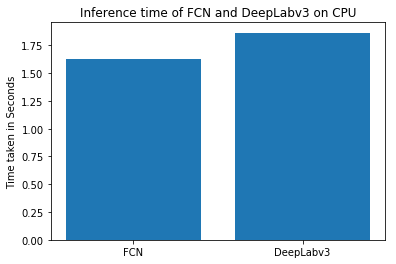

In [0]:
plt.bar([0.1, 0.2], [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on CPU')
plt.show()

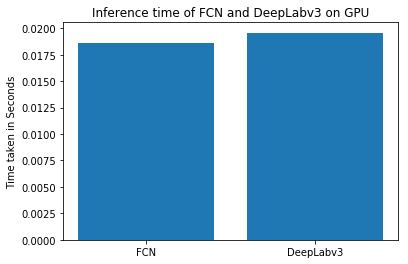

In [0]:
plt.bar([0.1, 0.2], [fcn_infer_time_avg_gpu, dlab_infer_time_avg_gpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on GPU')
plt.show()

Okay! Now, let's move on to the next comparison, where we will compare the model sizes for both the models.

### Model Size

In [0]:
import os

resnet101_size = os.path.getsize('/root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth')
fcn_size = os.path.getsize('/root/.cache/torch/checkpoints/fcn_resnet101_coco-7ecb50ca.pth')
dlab_size = os.path.getsize('/root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth')

fcn_total = fcn_size + resnet101_size
dlab_total = dlab_size + resnet101_size
    
print ('Size of the FCN model with Resnet101 backbone is:       {:.2f} MB'.format(fcn_total /  (1024 * 1024)))
print ('Size of the DeepLabv3 model with Resnet101 backbone is: {:.2f} MB'.format(dlab_total / (1024 * 1024)))

Size of the FCN model with Resnet101 backbone is:       378.16 MB
Size of the DeepLabv3 model with Resnet101 backbone is: 403.67 MB


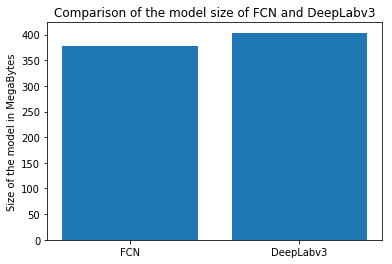

In [0]:
plt.bar([0, 1], [fcn_total / (1024 * 1024), dlab_total / (1024 * 1024)])
plt.ylabel('Size of the model in MegaBytes')
plt.xticks([0, 1], ['FCN', 'DeepLabv3'])
plt.title('Comparison of the model size of FCN and DeepLabv3')
plt.show()

## Conclusion

Hope you enjoyed this tutorial!

Feel free to leave comments and any feedback you wish! If you would like to learn<br/>
more about this, how these techniques work and how to implement these models!

Please do check out the `Deep Learning with PyTorch` Course from OpenCV.org! <br/>
Link: https://opencv.org/ai-courses-by-opencv-kickstarter-campaign/

# Test the performance on VOC2012

In [1]:
from torchvision.datasets import VOCSegmentation

voc = VOCSegmentation('.', download=True)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar


In [2]:
from torchvision import models
from PIL import Image
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import torch
import torchvision.transforms as T

nc = 21
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

trf = T.Compose([#T.Resize(640), 
                 #T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])


def fast_hist(a, b, n):
  k = (a >= 0) & (a < n) & (b >= 0) & (b < n)
  return np.bincount(n * a[k].astype(int) + b[k], minlength=n**2).reshape(n, n)

  
def evaluate(preds: np.array, labels: np.array):
  hist = fast_hist(labels.reshape(-1), preds.reshape(-1), 20)
  acc_total = np.diag(hist).sum() / hist.sum()
  iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
  return np.nanmean(acc_total), np.nanmean(iu)


def output(hist):
  acc = np.diag(hist) / hist.sum(1)
  iu = np.diag(hist) / (hist.sum(0) + hist.sum(1) - np.diag(hist))
  avg_acc = np.nanmean(np.diag(hist).sum() / hist.sum())
  avg_iu = np.nanmean(iu)
  
  print('acc', acc)
  print('avg_acc', avg_acc)
  print('iu', iu)
  print('avg_iu', avg_iu)
  print('hist', hist)

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## FCN

In [3]:
fcn_hist = np.zeros((nc, nc))

for line in tqdm(open('VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt')):
  img_id = line.strip()
  img_path = f'VOCdevkit/VOC2012/JPEGImages/{img_id}.jpg'
  gt_path = f'VOCdevkit/VOC2012/SegmentationClass/{img_id}.png'
  
  img = Image.open(img_path)
  gt = np.array(Image.open(gt_path))
  inp = trf(img).unsqueeze(0).to('cuda')
  out = fcn.to('cuda')(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  fcn_hist += fast_hist(gt.reshape(-1), om.reshape(-1), nc)

output(fcn_hist)


acc [0.9723807  0.91668473 0.84787602 0.89103879 0.77165438 0.60315063
 0.94874364 0.83699277 0.9214267  0.6692932  0.88449443 0.75363191
 0.88349152 0.89899154 0.85526157 0.9492843  0.66508203 0.87447259
 0.80514107 0.87462966 0.78887532]
avg_acc 0.9443049367079753
iu [0.93799075 0.87568381 0.39772613 0.86388439 0.68367622 0.56467537
 0.93803626 0.76189293 0.87661258 0.4742818  0.83479095 0.63627013
 0.80557723 0.84508941 0.79731148 0.89513972 0.55911197 0.83951143
 0.59410383 0.84469237 0.7529205 ]
avg_iu 0.7513799642204753
hist [[1.74587257e+08 4.52930000e+04 8.45495000e+05 6.42170000e+04
  1.57517000e+05 1.11184000e+05 3.53510000e+04 2.98208000e+05
  1.11838000e+05 6.27121000e+05 3.97040000e+04 4.85937000e+05
  6.71900000e+04 4.34100000e+04 1.10463000e+05 5.79010000e+05
  2.11783000e+05 4.37260000e+04 8.86309000e+05 1.10843000e+05
  8.43420000e+04]
 [1.57921000e+05 1.76353000e+06 0.00000000e+00 1.00000000e+00
  3.70000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.000000

## DeepLabv3

In [4]:
dlab_hist = np.zeros((21, 21))

for line in tqdm(open('VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt')):
  img_id = line.strip()
  img_path = f'VOCdevkit/VOC2012/JPEGImages/{img_id}.jpg'
  gt_path = f'VOCdevkit/VOC2012/SegmentationClass/{img_id}.png'
  
  img = Image.open(img_path)
  gt = np.array(Image.open(gt_path))
  inp = trf(img).unsqueeze(0).to('cuda')
  out = dlab.to('cuda')(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  dlab_hist += fast_hist(gt.reshape(-1), om.reshape(-1), 21)

output(dlab_hist)


acc [0.96852678 0.94194238 0.8766973  0.94948801 0.82000782 0.75183697
 0.9694854  0.84000463 0.96951853 0.70076809 0.94611277 0.72701143
 0.94726768 0.94735832 0.95778955 0.94949746 0.75618721 0.95185443
 0.86412961 0.94385386 0.79506579]
avg_acc 0.9519488953218914
iu [0.94373966 0.88522064 0.41182661 0.88041889 0.68937174 0.67384052
 0.95309741 0.7618359  0.9368853  0.46531799 0.92551851 0.63743694
 0.90489426 0.91879096 0.88579144 0.89829182 0.61310804 0.88967364
 0.64152949 0.90612432 0.74453541]
avg_iu 0.7889166421738862
hist [[1.73895301e+08 4.88630000e+04 8.81417000e+05 1.62246000e+05
  2.32079000e+05 2.12185000e+05 6.26700000e+04 3.43430000e+05
  1.43153000e+05 7.96860000e+05 3.04290000e+04 3.74934000e+05
  1.17292000e+05 6.27750000e+04 1.45478000e+05 5.70928000e+05
  2.61456000e+05 9.02320000e+04 8.38308000e+05 1.56296000e+05
  1.19866000e+05]
 [1.10502000e+05 1.81212100e+06 0.00000000e+00 4.70000000e+01
  4.20000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.000000

## Visualization

In [0]:
# Define the helper function
def decode_segmap(image, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb


def segment(net, path, dev='cuda'):
  img = Image.open(path)
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  return rgb

### FCN

VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000061.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000123.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000129.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000175.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000187.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000323.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000332.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000346.jpg


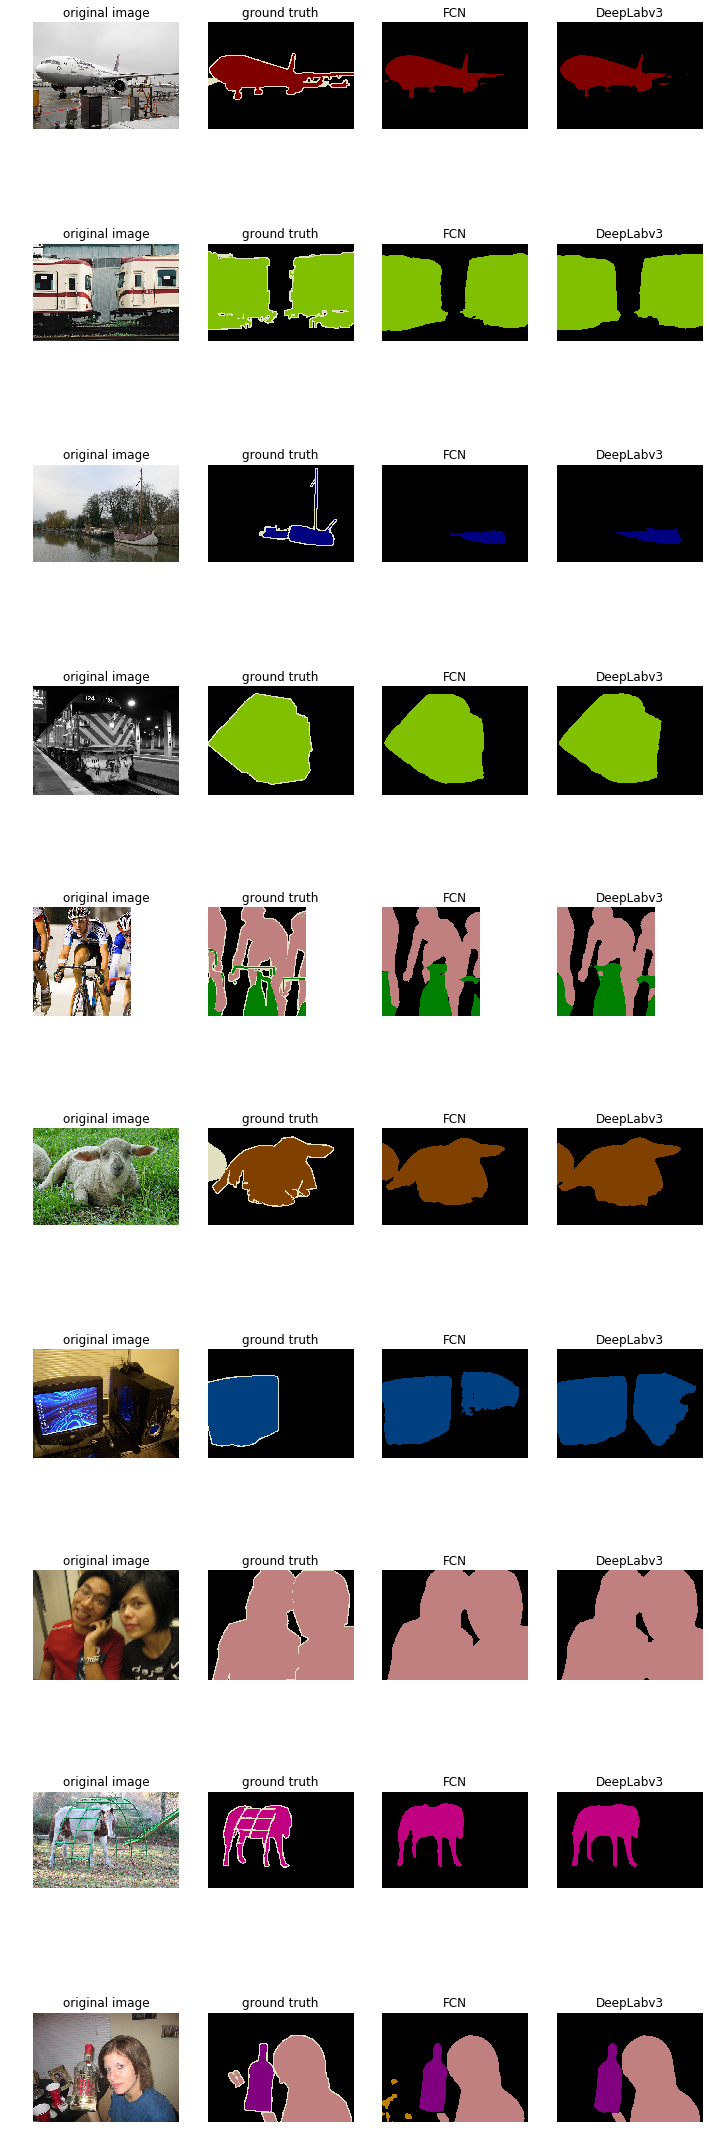

In [21]:
import matplotlib.image as mpimg


fig, ax = plt.subplots(10, 4, figsize=(12, 4*10), sharex='all', sharey='all')

for i, line in enumerate(open('VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt').readlines()[:10]):
  img_id = line.strip()
  img_path = f'VOCdevkit/VOC2012/JPEGImages/{img_id}.jpg'
  gt_path = f'VOCdevkit/VOC2012/SegmentationClass/{img_id}.png'
  print(img_path)

  ax[i, 0].axis('off')
  ax[i, 0].imshow(mpimg.imread(img_path))
  ax[i, 0].set_title('original image')
  ax[i, 1].axis('off')
  ax[i, 1].imshow(mpimg.imread(gt_path, 0))
  ax[i, 1].set_title('ground truth')
  ax[i, 2].axis('off')
  ax[i, 2].imshow(segment(fcn, img_path))
  ax[i, 2].set_title('FCN')
  ax[i, 3].axis('off')
  ax[i, 3].imshow(segment(dlab, img_path))
  ax[i, 3].set_title('DeepLabv3')

### DeepLabv3

VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000042.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000061.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000123.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000129.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000175.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000187.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000323.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000332.jpg
VOCdevkit/VOC2012/JPEGImages/2007_000346.jpg


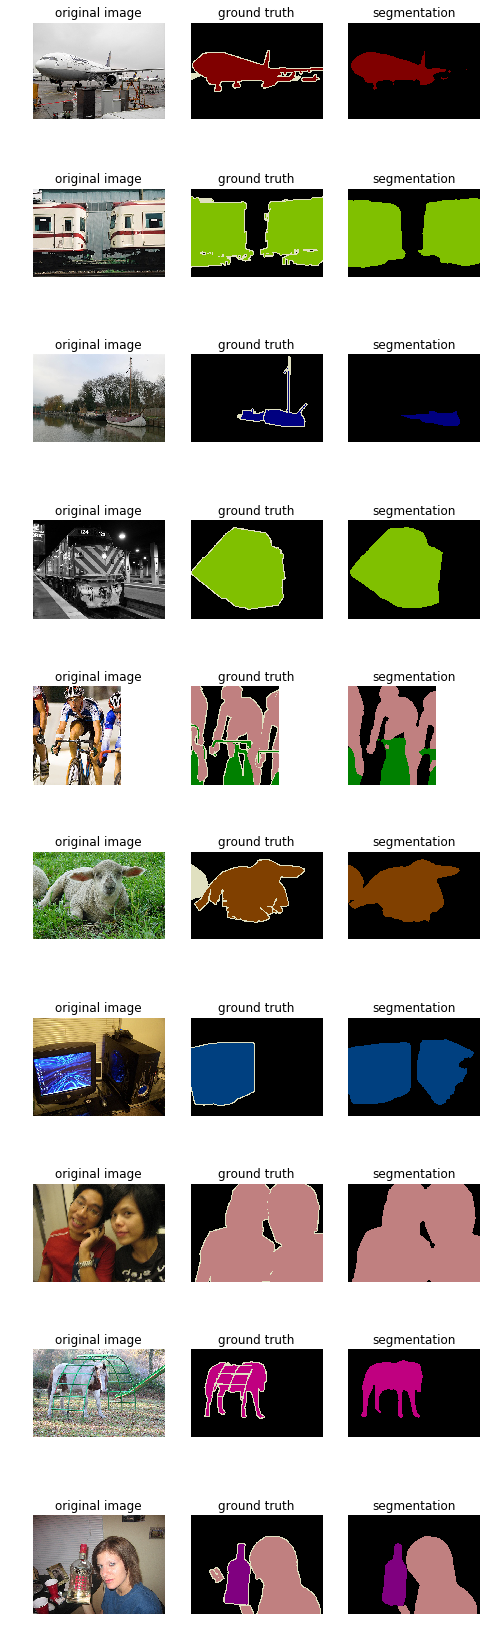

In [0]:
import matplotlib.image as mpimg


fig, ax = plt.subplots(10, 3, figsize=(8, 3*10), sharex='all', sharey='all')

for i, line in enumerate(open('VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt').readlines()[:10]):
  img_id = line.strip()
  img_path = f'VOCdevkit/VOC2012/JPEGImages/{img_id}.jpg'
  gt_path = f'VOCdevkit/VOC2012/SegmentationClass/{img_id}.png'
  print(img_path)

  ax[i, 0].axis('off')
  ax[i, 0].imshow(mpimg.imread(img_path))
  ax[i, 0].set_title('original image')
  ax[i, 1].axis('off')
  ax[i, 1].imshow(mpimg.imread(gt_path, 0))
  ax[i, 1].set_title('ground truth')
  ax[i, 2].axis('off')
  ax[i, 2].imshow(segment(dlab, img_path))
  ax[i, 2].set_title('segmentation')